### Trying PCA to reduce the number of features
### Term frequency data

In [1]:
import numpy as np #Handle computations 
import matplotlib.pyplot as plt #Visualisations
import pandas as pd #I/O

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, normalize, scale
from sklearn.svm import SVC #Support Vector Machine Classification
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score, auc

from scipy import sparse #I/O for .npz files (Scipy Sparse Matrices)

In [2]:
#Import the Processed Dataset and ratings

reviews_subset = sparse.load_npz('./data/reviews_subset_tfidf.npz')
ratings_subset = pd.read_csv('./data/ratings_subset.csv', header=None)


In [3]:
#Formatting
X = reviews_subset
y = np.asarray(ratings_subset)[:, 1]

In [4]:
X.shape

(100000, 42582)

There are 42,582 features over 100k reviews using bag of words method. 

In [5]:
# Training 80%, Testing 20%
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

PCA does not work well wih term frequency - inverse document frequency data (TF-IDF) because the data is sparse.

In [6]:
from sklearn.decomposition import TruncatedSVD

Search for a good number of components

In [28]:
tsd = TruncatedSVD(n_components=400)
tsd.fit(X_train)
csum = np.cumsum(tsd.explained_variance_ratio_)
d = np.argmax(csum >= 0.95) + 1

In [23]:
d

1

In [32]:
tsd.explained_variance_ratio_.sum()

0.4084440850083364

Not a good size, but at least the code works.

In [33]:
sizes = [1000]
exp_var = []

for size in sizes:
    
    tsd = TruncatedSVD(n_components=size)
    tsd.fit(X_train)
    exp_var.append( tsd.explained_variance_ratio_.sum() )

In [34]:
exp_var

[0.5803813587048551]

In [7]:
import time

In [42]:
tic = time.clock()

In [43]:
toc = time.clock()
toc-tic

5.432205142634558

In [45]:
#sizes = [1000, 5000, 10000, 20000]
sizes = [5000]
exp_var = []
time_taken = []

for size in sizes:
    tic = time.clock()
    tsd = TruncatedSVD(n_components=size)
    tsd.fit(X_train)
    exp_var.append( tsd.explained_variance_ratio_.sum() )
    toc = time.clock()
    time_taken.append( toc - tic )

In [46]:
time_taken

[3007.8089505625207]

In [47]:
exp_var

[0.8615862514009559]

Much better! Close to the 95% mark

In [60]:
#Method to do by thousands (if time permits)
s = np.asarray(range(1,11))*1000

In [61]:
s

array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000])

Next two 500, trying to find break 95%!

In [63]:
sizes = [5500, 6000]

for size in sizes:
    tic = time.clock()
    tsd = TruncatedSVD(n_components=size)
    tsd.fit(X_train)
    exp_var.append( tsd.explained_variance_ratio_.sum() )
    toc = time.clock()
    time_taken.append( toc - tic )

In [64]:
exp_var

[0.8615862514009559, 0.8739526732164602, 0.8847195069913367]

In [65]:
time_taken

[3007.8089505625207, 3725.907953959657, 4900.412016209102]

In [67]:
s = [5000, 5500, 6000]

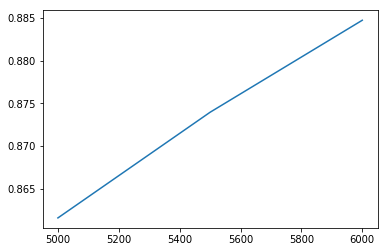

In [68]:
plt.plot(s, exp_var)

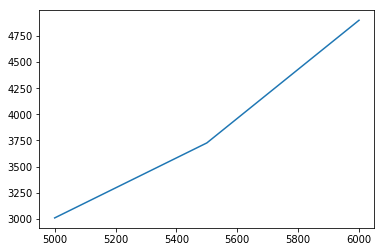

In [72]:
plt.plot(s, time_taken)

In [73]:
sizes = [8000, 10000]

for size in sizes:
    tic = time.clock()
    tsd = TruncatedSVD(n_components=size)
    tsd.fit(X_train)
    exp_var.append( tsd.explained_variance_ratio_.sum() )
    toc = time.clock()
    time_taken.append( toc - tic )

MemoryError: 

In [74]:
exp_var

[0.8615862514009559, 0.8739526732164602, 0.8847195069913367]

8000 is too large in terms of memory constraints. Not much difference (2%) between 5000 Stick with 5000 dimensions.

In [9]:
# do truncated svd on many for a nice plot
sizes = [1000, 2000, 3000, 4000, 5000]
exp_var = []
time_taken = []

for size in sizes:
    tic = time.clock()
    tsd = TruncatedSVD(n_components=size)
    tsd.fit(X)
    exp_var.append( tsd.explained_variance_ratio_.sum() )
    toc = time.clock()
    time_taken.append( toc - tic )

In [19]:
sizes = [1000, 2000, 3000, 4000, 5000]

In [22]:
exp_var

[0.5791354523933419,
 0.7129816376354452,
 0.7835758881028232,
 0.8280216552962598,
 0.8590617212746122]

In [23]:
time_taken

[229.93367658160003,
 624.4775245528551,
 1289.9830577163139,
 2691.509833915855,
 4335.22586771853]

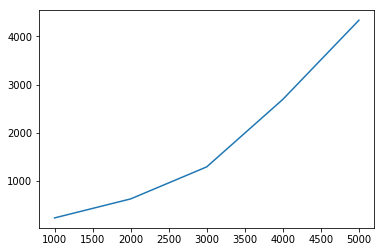

In [21]:
plt.plot(sizes, time_taken)


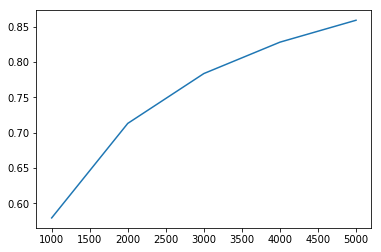

In [20]:
plt.plot(sizes, exp_var)

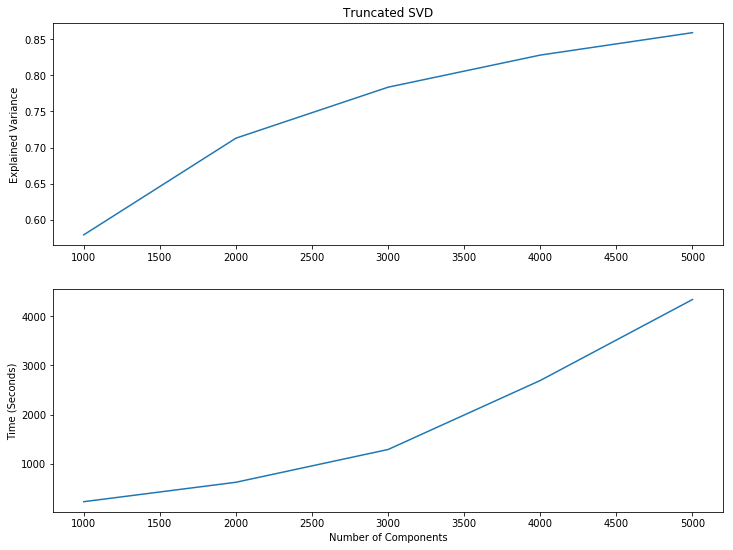

In [28]:
plt.figure(figsize=(12,9))

plt.subplot(211)
plt.plot(sizes, exp_var)
plt.ylabel('Explained Variance')
plt.title('Truncated SVD')

plt.subplot(212)
plt.plot(sizes, time_taken)
plt.ylabel('Time (Seconds)')
plt.xlabel('Number of Components')

plt.show()

Export transform of X to file for use later. Need to redo the fit because of memory error trying for 6000.

In [8]:
sizes = [5000]

for size in sizes:
    tic = time.clock()
    tsd = TruncatedSVD(n_components=size)
    tsd.fit(X_train)
    #exp_var.append( tsd.explained_variance_ratio_.sum() )
    toc = time.clock()
    #time_taken.append( toc - tic )
    toc-tic

In [9]:
X_svd = tsd.transform(X)

In [10]:
X_svd.to_csv(path='./data/reviews_svd.csv')

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [11]:
type(X_svd)

numpy.ndarray

In [14]:
np.savetxt('./data/reviews_svd.csv', X_svd, delimiter=',')

Resulting dense matrix is 11GB. Probably not a great idea to use SVD. In relation, the prior sparse dataset is 70kb.

Trying h5py to store the reviews_svd data:

In [15]:
import h5py

In [16]:
h5file = h5py.File('./data/reviews_svd.h5', 'w')
h5file.create_dataset('reviews_svd', data=X_svd)

h5file.close()

This file is 3GB. Much better size-wize! With the added value of saving faster.